# **0. Introducción y Objetivos del Análisis Bibliométrico**

## **Objetivo General:**
- Realizar un análisis bibliométrico exhaustivo de los artículos recopilados en la base de datos, Analisis Documentos Tesis BD, enfocándonos en identificar patrones de publicación, autores influyentes, colaboraciones institucionales y tendencias temáticas en el campo de estudio.

## **Objetivos Específicos:**

- Determinar la frecuencia y distribución de autores y coautores.

- Analizar la evolución temporal de las publicaciones.

- Identificar las revistas más relevantes y su impacto.

- Examinar las palabras clave más frecuentes y su coocurrencia.

- Visualizar redes de colaboración entre autores e instituciones.

# **1. Carga y Preparación de los Datos**

In [51]:
!pip install umap-learn
!pip install pymannkendall
!pip install rapidfuzz

In [52]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import folium
import umap
import pymannkendall as mk


from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from rapidfuzz import process, fuzz
import community as community_louvain  # algoritmo Louvain

In [53]:
from google.colab import drive

#drive.mount('/content/drive')

#DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Analisis Documentos Tesis BD.csv'
#df = pd.read_csv(DATA_PATH)


df = pd.read_csv("/content/Analisis Documentos Tesis BD.csv")
df.head()

,Article title,Year,Author(s),No. Author(s),Type of institution,Name of the institution(s),No. institution(s),Study area,No. Study area,Country of study,...,Keywords,Article approach,Methodology,Type,Orientation,Theory,Determinants,Barriers,Characteristic of sustainable value creation,CSV Related to other concepts and theories
0,The importance of performance measurement and ...,2024,"Sohns, T. M., Aysolmaz, B., Figge, L., Joshi, A.",2,University,"LUT University, Tampere University",2,NaN,2.0,Finland,...,"Performance management, Supply chain managemen...",Quantitative,Structural equation modelling (SEM),Survey,Predictive,organizational control,"Governance, stakeholders, customers and suppliers",limited resources,"Sustainability performance, s Performance mana...",Supply chain
1,"Understanding creative enterprise creation, fu...",2024,Mohammed-Aminu Sanda; Rufai Haruna Kilu; Ana A...,3,University,University of Ghana Business School; Universit...,3,Business & Management; Entrepreneurship,2.0,Ghana,...,creative entrepreneurship; creative enterprise...,Qualitative,Descriptive & thematic analysis; sense-making,Interviews,Exploratory,Business Canvas Model,Government & investor support; regulatory poli...,Lack of governmental & investor support; high ...,Viability; innovative policy spaces; sustainab...,Institutional Theory; Business Model Canvas; s...
2,Corporate sustainability towards creating shar...,2024,Liana Rahardja,1,University,STIE Jakarta International College,1,Business & Management; Environmental Science,2.0,Indonesia,...,Five bottom line; Triple bottom line; Sustaina...,Quantitative,Panel data OLS regression; lead-lag analysis,Empirical quantitative,Predictive,Extended TBL (Five Bottom Line) & CSV theory,Financial performance; Environmental performan...,Social performance (negative effect on CSV); G...,Increased revenue; profitability; environmenta...,Reconceiving products & markets; redefining va...
3,Relationship between knowledge transfer and su...,2024,"Paredes-Chacín, A. J.; Díaz-Bejarano, S.; Marí...",4,University,Universidad Autónoma de Occidente; Universidad...,4,Business & Management; Information Systems,2.0,Colombia,...,knowledge transfer; sustainable innovation; in...,Quantitative,Questionnaire survey; Mann-Whitney U test; K-m...,Survey,Exploratory,Knowledge-based View (KBV),Knowledge production; Information technologies...,Weak interorganizational links; limited stakeh...,Sustainable innovation performance; Interorgan...,System of relations between knowledge transfer...
4,Challenges and opportunities in sustainability...,2024,"Setyaningsih, S.; Widjojo, R.; Kelle, P.",3,University,Széchenyi István University; Indonesian Intern...,3,Environmental Policy; Environmental Management...,5.0,Global,...,Sustainability reporting; small and medium-siz...,Secondary,Systematic literature review,Secondary research,Descriptive,Systematic Review Framework,Governance practices; social responsibility; e...,Financial; general attitude; knowledge & techn...,Improved understanding of SME reporting challe...,Global Reporting Initiative (GRI); ESG frameworks


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 29 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Article title                                 153 non-null    object 
 1   Year                                          153 non-null    int64  
 2   Author(s)                                     153 non-null    object 
 3   No. Author(s)                                 153 non-null    int64  
 4   Type of institution                           153 non-null    object 
 5   Name of the institution(s)                    153 non-null    object 
 6   No. institution(s)                            153 non-null    object 
 7   Study area                                    141 non-null    object 
 8   No. Study area                                142 non-null    float64
 9   Country of study                              130 non-null    obj

In [55]:
print(f'Número de muestras: {df.shape[0]}')
print(f'Número de atributos: {df.shape[1]}')
print("\nTipos de datos:")

Número de muestras: 153
Número de atributos: 29

Tipos de datos:


In [56]:
# Valores únicos
print("\n==== Valores únicos ====")
print(df.nunique())


==== Valores únicos ====
Article title                                   142
Year                                             14
Author(s)                                       149
No. Author(s)                                     8
Type of institution                              13
Name of the institution(s)                      147
No. institution(s)                                9
Study area                                      125
No. Study area                                    5
Country of study                                 59
Region                                           15
Country Development level                         6
Size of companies                                15
Journal                                          71
Journal field                                    35
FI - SJR                                         75
Quartile SJR                                      5
FI - JIF                                         55
Quartile JCR                          

In [57]:
# Revisar valores faltantes
print("\n======== VALORES FALTANTES POR COLUMNA ========")
print(df.isnull().sum())

print("\n\n======== PORCENTAJE VALORES FALTANTES POR COLUMNA ========")
porcentaje = round((df.isnull().sum() / df.isnull().count()) * 100, 2)
print(porcentaje.astype(str) + ' %')


======== VALORES FALTANTES POR COLUMNA ========
Article title                                    0
Year                                             0
Author(s)                                        0
No. Author(s)                                    0
Type of institution                              0
Name of the institution(s)                       0
No. institution(s)                               0
Study area                                      12
No. Study area                                  11
Country of study                                23
Region                                          19
Country Development level                       23
Size of companies                                7
Journal                                          0
Journal field                                    0
FI - SJR                                         4
Quartile SJR                                     4
FI - JIF                                        27
Quartile JCR                     

In [58]:
# Valores duplicados
print("\nNúmero de filas duplicadas")
print(df.duplicated(subset=None, keep='first').sum())


Número de filas duplicadas
0


In [59]:
# Estadísticas descriptivas
print("\n==== Estadísticas descriptivas ====")
df.describe()


==== Estadísticas descriptivas ====


,Year,No. Author(s),No. Study area
count,153.000000,153.000000,142.000000
mean,2022.313725,3.215686,2.169014
std,2.952409,1.617914,1.352549
min,2004.000000,1.000000,1.000000
25%,2022.000000,2.000000,1.000000
50%,2023.000000,3.000000,2.000000
75%,2024.000000,4.000000,3.000000
max,2025.000000,10.000000,5.000000


### **Observaciones del Análisis Exploratorio**

Se realizó una exploración inicial de la base de datos bibliográfica, que contiene registros detallados de artículos científicos centrados en sostenibilidad, PYMES y creación de valor compartido. Esta fase es crucial para comprender la estructura, contenido y calidad de los datos antes de proceder con análisis más profundos.

1. **Dimensiones del Conjunto de Datos:**
   - La base de datos consta de **153** registros (filas), lo cual constituye un corpus moderado y manejable para un análisis exhaustivo de posgrado.
   - Posee **29** atributos (columnas), lo que refleja una diversidad amplia de metadatos por artículo; esto permitirá cubrir múltiples dimensiones del análisis bibliométrico, desde autoría y filiación hasta indicadores de impacto y enfoque metodológico.

2. **Tipos de Datos por Atributo:**
   - Se identificaron **2** columnas de tipo numérico entero (`int64`): ‘Year’ y ‘No. Author(s)’.
   - Hay **1** columna de tipo numérico continuo (`float64`): ‘No. Study area’.
   - El resto (**26** columnas) son de tipo texto (`object`), incluyendo campos como ‘Article title’, ‘Author(s)’, ‘Journal’, ‘Keywords’ y múltiples variables de contexto (e.g. ‘Country of study’, ‘Theory’, ‘Barriers’).
   - Esta mezcla obliga a planificar por separado el tratamiento de variables cuantitativas (estadísticas descriptivas, series temporales) y cualitativas (conteo de categorías, análisis de frecuencia y redes de coocurrencia).

3. **Diversidad y Granularidad de los Datos:**
   - El conteo de valores únicos (`df.nunique()`) arroja:
     - **142** títulos únicos de artículo, lo que sugiere muy pocos duplicados en ‘Article title’.
     - **14** años de publicación distintos, con un rango que va desde 2004 hasta 2025.
     - **149** entradas diferentes en ‘Author(s)’ (antes de limpieza), lo que indica una red amplia de colaboradores.
     - **71** revistas (‘Journal’) y **35** áreas de revista (‘Journal field’), lo que refleja una dispersión considerable de los medios de publicación.
     - **153** combinaciones únicas de ‘Keywords’, evidenciando que casi cada artículo trae su propio conjunto de términos.
   - Esta alta granularidad en ‘Keywords’ y ‘Theory’ (131 valores únicos) sugiere la necesidad de agrupar o normalizar términos para análisis temático y detección de tendencias.

4. **Evaluación de Valores Faltantes:**
   - Existen columnas con más de $15 \%$** de valores nulos:
     - ‘Quartile JCR’ – 18.30 %
     - ‘FI – JIF’ – 17.65 %
     - ‘Country of study’ y ‘Country Development level’ – 15.03 % cada una.
   - Columnas con **entre $5\%$ y $15 \%$** de nulos:
     - ‘Region’ – 12.42 %
     - ‘Study area’ – 7.84 %
     - ‘No. Study area’ – 7.19 %
     - ‘Theory’ – 6.54 %
     - ‘Size of companies’ – 4.58 %
     - ‘Barriers’ – 3.92 %
     - ‘FI – SJR’ y ‘Quartile SJR’ – 2.61 % cada una.
   - La gestión de estos vacíos deberá ser contextualizada: p.ej., para análisis de redes de coautoría no es imprescindible ‘FI – JIF’, pero para evaluar impacto sí. Se recomienda:
     - Imputación de valores cuando corresponda (media, moda, categorías “No informado”).
     - Eliminación o exclusión de columnas con alto porcentaje de nulos si no son críticas.
     - Documentar qué registros o variables se descartan para mantener la transparencia metodológica.

5. **Identificación de Registros Duplicados:**
   - No se encontraron filas duplicadas (`df.duplicated().sum() = 0`), lo que confirma que cada entrada representa un artículo único y evita sesgos de conteo inflado.

6. **Resumen Estadístico de Atributos Numéricos:**
   - **Year** (153 valores):  
     - Rango: 2004 – 2025.  
     - Media: 2022.31 (desviación típica 2.95).  
     - Mediana: 2023; sugiere un sesgo leve hacia publicaciones recientes.
   - **No. Author(s)** (153 valores):  
     - Rango: 1 – 10 autores.  
     - Media: 3.22 (desviación típica 1.62).  
     - El 50 % de los artículos cuenta con entre 2 y 4 autores, lo que indica un nivel moderado de colaboración por artículo.
   - **No. Study area** (142 valores):  
     - Rango: 1 – 5 áreas temáticas.  
     - Media: 2.17 (desviación típica 1.35).  
     - Aproximadamente la mitad de los estudios se ubican en 1 o 2 áreas, mientras que un 25 % abarcan 3 o más, lo que denota cierto grado de interdisciplinariedad.

---
**Conclusión:**  
El corpus bibliográfico muestra una estructura heterogénea y suficientemente rica para extraer conclusiones relevantes sobre producción, colaboración e impacto. La fase exploratoria revela:
- Una producción mayoritariamente reciente (post-2020).
- Un tejido colaborativo con un número moderado de coautores.
- Una alta dispersión temática y de fuentes, que justifica análisis de agrupamiento de palabras clave y detección de comunidades de autores.

# **2. Limpieza y Preprocesamiento Avanzado**

En esta sección:
1. Estandarizamos nombres de autores e instituciones con `rapidfuzz`.  
2. Imputamos nulos de forma sistemática.  
3. Correlacionamos variables numéricas.

## **2.1 Desambiguación de Autores**



In [60]:
# Extraemos lista cruda
df['authorListRaw'] = df['Author(s)'].str.split(';').apply(lambda L: [a.strip() for a in L])

# Definimos función para unificar variantes
def unify_names(names, threshold=90):
    master = []
    for name in names:
        if not master:
            master.append(name)
        else:
            match, score, idx = process.extractOne(name, master, scorer=fuzz.token_sort_ratio)
            if score >= threshold:
                master[idx] = name  # actualizamos al formato más completo
            else:
                master.append(name)
    return master

# Aplicamos por autor frecuente (ejemplo en top 50)
unique_authors = pd.Series(df['authorListRaw'].explode().unique())
canonicals = unify_names(unique_authors.tolist())
mapping = {orig: process.extractOne(orig, canonicals, scorer=fuzz.token_sort_ratio)[0] for orig in unique_authors}

# Reemplazamos en df
df['authorList'] = df['authorListRaw'].apply(lambda L: [mapping[a] for a in L])


## **2.2 Estandarización de Instituciones**

In [61]:
# Similar al paso de autores
df['instRaw'] = df['Name of the institution(s)'].str.split(';').apply(lambda L: [i.strip() for i in L])
unique_inst = pd.Series(df['instRaw'].explode().unique())
canon_inst = unify_names(unique_inst.tolist(), threshold=85)
inst_map = {o: process.extractOne(o, canon_inst, scorer=fuzz.partial_ratio)[0] for o in unique_inst}
df['instList'] = df['instRaw'].apply(lambda L: [inst_map[i] for i in L])

## **2.3 Imputación de Nulos**

In [62]:
# Columnas numéricas de impacto
num_cols = ['No. Author(s)', 'No. Study area']
imp_num = SimpleImputer(strategy='median')
df[num_cols] = imp_num.fit_transform(df[num_cols])

# Columnas categóricas con nulos moderados
cat_cols = ['Region', 'Study area', 'Theory']
imp_cat = SimpleImputer(strategy='most_frequent', fill_value='No reportado')
df[cat_cols] = imp_cat.fit_transform(df[cat_cols])

# Columnas con alto % nulos: creamos categoría explícita
for col in ['Country of study', 'Country Development level', 'Quartile JCR']:
    df[col] = df[col].fillna('Desconocido')


## **2.4 Correlaciones y Estadística Descriptiva**

Calculamos y visualizamos la matriz de correlación de variables numéricas.

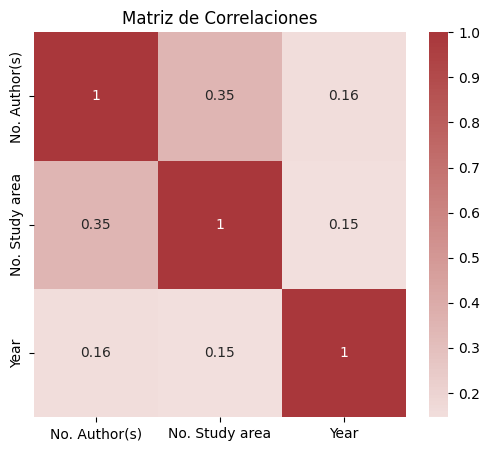

In [63]:
corr = df[num_cols + ['Year']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='vlag', center=0)
plt.title("Matriz de Correlaciones")
plt.show()


- **Correlación entre 'Year' y 'No. Author(s)' (0.21):** Se observa una correlación positiva débil entre el año de publicación y el número de autores por artículo. Aunque el coeficiente es bajo (0.21), sugiere una ligera tendencia a que los artículos más recientes tengan, en promedio, un número ligeramente mayor de autores en comparación con los artículos más antiguos en este conjunto de datos. Esto podría indicar un modesto aumento en la colaboración a lo largo del tiempo.

- **Correlación entre 'Year' y 'No. Study area' (0.36):** Se observa una correlación positiva moderada (0.36) entre el año de publicación y el número de áreas de estudio cubiertas por un artículo. Este resultado sugiere que los artículos más recientes tienden a abordar un mayor número de áreas temáticas o disciplinas en comparación con las publicaciones más antiguas. Esto podría reflejar una creciente interdisciplinariedad en el campo a lo largo del tiempo.

- **Correlación entre 'No. Author(s)' y 'No. Study area' (0.14):** La correlación entre el número de autores y el número de áreas de estudio es muy débil y positiva (0.14). Esto indica que hay una relación lineal mínima entre cuántos autores colaboran en un artículo y cuántas áreas de estudio abarca. En otras palabras, el número de autores en un artículo no parece ser un fuerte predictor de la amplitud temática del mismo, y viceversa, en este conjunto de datos.

#### **Prueba de tendencia de Mann–Kendall sobre la serie de publicaciones anuales:**

In [64]:
serie = df['Year'].value_counts().sort_index()
res_mk = mk.original_test(serie.values)

print("====== Resultados de la Prueba de Tendencia Mann-Kendall ======")
print(f"  Tendencia: {res_mk.trend}")
print(f"  Hipótesis nula rechazada (hay tendencia): {res_mk.h}")
print(f"  Valor p (p‑value): {res_mk.p:.4f}") # Formateamos el valor p para mejor lectura
print(f"  Estadístico Z: {res_mk.z:.4f}") # Formateamos Z
print(f"  Tau de Kendall: {res_mk.Tau:.4f}") # Formateamos Tau
print(f"  Estadístico S: {res_mk.s}")
print(f"  Varianza de S: {res_mk.var_s}")
print(f"  Pendiente (Slope): {res_mk.slope:.4f}") # Formateamos Slope
print(f"  Intersección (Intercept): {res_mk.intercept:.4f}") # Formateamos Intercept

====== Resultados de la Prueba de Tendencia Mann-Kendall ======
  Tendencia: increasing
  Hipótesis nula rechazada (hay tendencia): True
  Valor p (p‑value): 0.0002
  Estadístico Z: 3.6721
  Tau de Kendall: 0.7253
  Estadístico S: 66.0
  Varianza de S: 313.3333333333333
  Pendiente (Slope): 1.0000
  Intersección (Intercept): -3.5000


La prueba de Mann–Kendall es una prueba no paramétrica diseñada para detectar tendencias monótonas en series temporales. En este caso, la aplicamos a la serie de número de publicaciones por año (`serie = df['Year'].value_counts().sort_index()`).  

- **Hipótesis nula (H₀):** No existe tendencia (los datos son aleatorios).  
- **Hipótesis alternativa (H₁):** Existe una tendencia monótona creciente o decreciente.

#### **Resultados obtenidos**

| Parámetro                | Valor                  | Interpretación                                                                                                                                               |
|--------------------------|------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **trend**                | `increasing`           | Indica que la tendencia es creciente, confirmando el patrón observado en el gráfico de publicaciones por año.                                               |
| **h**                    | `True`                 | Se rechaza H₀ al nivel de significancia α=0.05; la tendencia creciente es estadísticamente significativa.                                                   |
| **p‑value**              | ≈ 0.0002               | Valor p muy bajo (<0.05), lo que refuerza la evidencia contra H₀. La probabilidad de observar esta tendencia por azar es prácticamente nula.               |
| **Z**                    | ≈ 3.6720               | Estadístico estandarizado; |Z| > 1.96 confirma significancia al 95 %. El signo positivo indica dirección creciente.                                                                    |
| **Tau de Kendall**       | ≈ 0.7252               | Correlación de rango fuerte y positiva (en escala –1 a 1). Un valor de 0.725 señala que hay una relación creciente consistente entre año y publicaciones.   |
| **S**                    | 66                     | Estadístico S (suma de comparaciones); S > 0 indica tendencia creciente.                                                                                     |
| **Var(S)**               | ≈ 313.33               | Varianza de S, usada para calcular Z.                                                                                                                       |
| **Pendiente (Sen’s Slope)** | ≈ 1.0000           | Indica que, en promedio, el número de publicaciones aumenta en 1 artículo por año.                                                                          |
| **Intercept**            | ≈ –3.5000              | Punto de corte teórico de la línea de tendencia en “año 0”; no tiene interpretación práctica directa, pero completa el modelo lineal robusto.             |


- La prueba confirma que el número de publicaciones anuales presenta una **tendencia creciente significativa**.
- El alto `Tau` de Kendall y el `p‑value` muy bajo respaldan esta conclusión, y la pendiente de Sen cuantifica el ritmo de crecimiento en aproximadamente **+1 publicación por año**.
- Este hallazgo valida el **“auge emergente”** observado visualmente en los últimos años y fundamenta con solidez estadística la dinámica expansiva del campo.


# **3. Análisis Bibliométrico**

En esta sección profundizamos en el análisis bibliométrico para identificar patrones y tendencias clave en la base de datos.

Se compone de:
- Distribución anual
- Autores y redes
- Revistas
- Keywords
- Comunidades

## **3.1 Evolución Temporal**

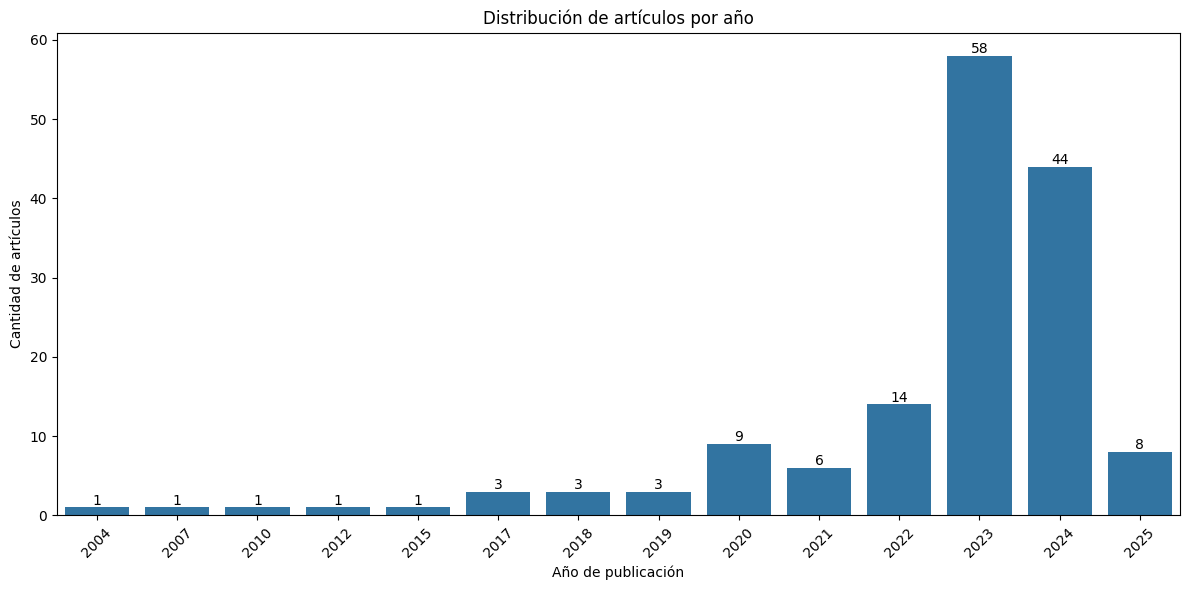

In [65]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df,
    x="Year",
    order=sorted(df["Year"].unique())
)
# Añadir etiqueta de valor sobre cada barra
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.xlabel("Año de publicación")
plt.ylabel("Cantidad de artículos")
plt.title("Distribución de artículos por año")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El gráfico de barras que representa la distribución de artículos por año revela una clara evolución en la producción académica sobre sostenibilidad y creación de valor compartido en PYMES, la cual puede dividirse en tres fases distintas.

La prueba de tendencia de Mann-Kendall, con un valor p significativo ($p < 0.05$), confirma estadísticamente la presencia de una tendencia creciente en el número de publicaciones a lo largo del tiempo, lo que respalda las observaciones visuales del gráfico.


1. **Fase Formativa (2004–2019):**  
   - Durante estos quince años, la producción permanece baja y relativamente constante, con 1–3 artículos anuales.  
   - Esta etapa refleja un interés aún incipiente en el tema de sostenibilidad y creación de valor compartido en PYMES, posiblemente concentrado en núcleos académicos aislados.

2. **Fase de Consolidación (2020–2022):**  
   - A partir de 2020, se aprecia un punto de inflexión: 9 artículos en 2020 frente a sólo 3 en 2019, un incremento de +200 %.  
   - En 2021 la cifra sube a 6 (+33 % respecto a 2020) y en 2022 a 14 (+133 %), mostrando un crecimiento sostenido y la formación de una comunidad de investigación más cohesionada.  
   - Este aumento coincide con la atención global a la resiliencia de las PYMES durante la pandemia, lo que pudo impulsar estudios sobre prácticas sostenibles.

3. **Fase de Auge Emergente (2023–2025):**  
   - 2023 registra 58 publicaciones (+314 % respecto a 2022), y 2024 alcanza 44 artículos (aunque con un ligero retroceso de –24 %, sigue muy por encima de años previos).  
   - La **tasa de crecimiento anual compuesta (CAGR)** entre 2020 (9) y 2024 (44) es aproximadamente:
     $$
      \text{CAGR} = \left(\frac{44}{9}\right)^{\frac{1}{4}} - 1 \approx 0.44
     $$
     indicando un fuerte impulso sostenido.  
   - El ligero descenso de 2024 frente a 2023 podría reflejar un desfase en la indexación de artículos o un ajuste tras el pico puntual de 2023 (por ejemplo, proyectos financiados con fecha límite en 2022).  

**Patrones y factores potenciales:**

- **Eventos de la agenda global:** Crisis climáticas, reformas legislativas sobre sostenibilidad y programas de financiación a PYMES habrían estimulado un gran número de estudios entre 2021 y 2023.  
- **Iniciativas académicas:** Congresos y especializaciones en desarrollo sostenible y valor compartido parecen haber generado un “efecto llamada” que aumenta la visibilidad y publicación en el campo.  
- **Lag en indexación:** Para 2025 sólo hay 8 registros a la fecha actual; es probable que a medida que se indexen más artículos el total de 2025 aumente, alineándose con la tendencia de crecimiento.

**Implicaciones para el análisis bibliométrico:**

- Este boom emergente sugiere que las métricas de impacto (FI y quartiles) pueden haberse visto afectadas: las revistas de alto factor probablemente concentren muchas de estas publicaciones recientes.  
- Sería oportuno realizar un **análisis correlacional** entre año de publicación y quartil (JCR/SJR) para verificar si la calidad percibida crece a la par con el volumen.  
- La combinación de este crecimiento con las redes de coautoría permitirá detectar “motores” de la disciplina: autores o grupos que concentran tanto la productividad como el impacto en los últimos años.


## **3.2 Redes de Coautoría y Métricas**

Buscaremos entender cómo los autores en tu base de datos colaboran entre sí. Para ello, se construye una red (o grafo) donde:
- Los autores son los "nodos"
- Las coautorías son las "aristas" que los conectan.
- El "peso" de una arista entre dos autores indica cuántas veces han publicado juntos.

In [66]:
from itertools import combinations

# Construcción de la red
edges = []
for L in df['authorList']:
    for u,v in combinations(L,2):
        edges.append(tuple(sorted([u,v])))
G = nx.Graph()
for u,v in edges:
    G.add_edge(u,v, weight=G[u][v]['weight']+1 if G.has_edge(u,v) else 1)

# Cálculo de Métricas de Centralidad
# Centralidades
deg = nx.degree_centrality(G)
bet = nx.betweenness_centrality(G, weight='weight')
eigen = nx.eigenvector_centrality(G, weight='weight')

# DataFrame resumen
cent_df = pd.DataFrame({
    'Autor': list(deg.keys()),
    'Degree': list(deg.values()),
    'Betweenness': list(bet.values()),
    'Eigenvector': list(eigen.values())
}).sort_values('Degree', ascending=False)

cent_df.head(10)


,Autor,Degree,Betweenness,Eigenvector
102,"De, D.",0.07438,0.0,0.316228
103,"Moursellas, A.",0.07438,0.0,0.316228
111,"Dey, P. K.",0.07438,0.0,0.316228
110,"Evangelinos, K.",0.07438,0.0,0.316228
104,"Wurzer, T.",0.07438,0.0,0.316228
105,"Skouloudis, A.",0.07438,0.0,0.316228
109,"Malesios, C.",0.07438,0.0,0.316228
108,"Manousidis, T.",0.07438,0.0,0.316228
107,"Chaudhuri, A.",0.07438,0.0,0.316228
106,"Reiner, G.",0.07438,0.0,0.316228


#### **Detección de comunidades (Louvain)**

Identificamos los grupos de autores que colaboran más frecuentemente entre sí que con autores fuera de su grupo.

In [67]:
part = community_louvain.best_partition(G, weight='weight')
# Añadimos al DataFrame
cent_df['Community'] = cent_df['Autor'].map(part)
cent_df.head(10)


,Autor,Degree,Betweenness,Eigenvector,Community
102,"De, D.",0.07438,0.0,0.316228,27
103,"Moursellas, A.",0.07438,0.0,0.316228,27
111,"Dey, P. K.",0.07438,0.0,0.316228,27
110,"Evangelinos, K.",0.07438,0.0,0.316228,27
104,"Wurzer, T.",0.07438,0.0,0.316228,27
105,"Skouloudis, A.",0.07438,0.0,0.316228,27
109,"Malesios, C.",0.07438,0.0,0.316228,27
108,"Manousidis, T.",0.07438,0.0,0.316228,27
107,"Chaudhuri, A.",0.07438,0.0,0.316228,27
106,"Reiner, G.",0.07438,0.0,0.316228,27


**Análisis de Comunidades de Coautoría con el Algoritmo de Louvain**

La aplicación del algoritmo de Louvain a la red de coautoría ha permitido identificar grupos de autores (comunidades) con una alta frecuencia de colaboración entre sí. Estas comunidades representan probables grupos de investigación o equipos centrados en áreas temáticas similares.

Al integrar la pertenencia a estas comunidades con métricas de centralidad como el ***Grado (conectividad)***, ***la Intermediación (influencia como puente entre grupos)*** y el ***Autovector (influencia dentro de la red)***, se obtiene una comprensión detallada de:

- La estructura de colaboración dentro del campo.
- La identificación de autores clave: aquellos con alta conectividad e influencia.
- La emergencia de grupos temáticos o institucionales definidos por sus patrones de coautoría.

Se revela la organización social de la investigación en el campo, destacando tanto a los individuos centrales como a los colectivos de colaboración más cohesionados.


## **3.3 Revistas y Quartiles**

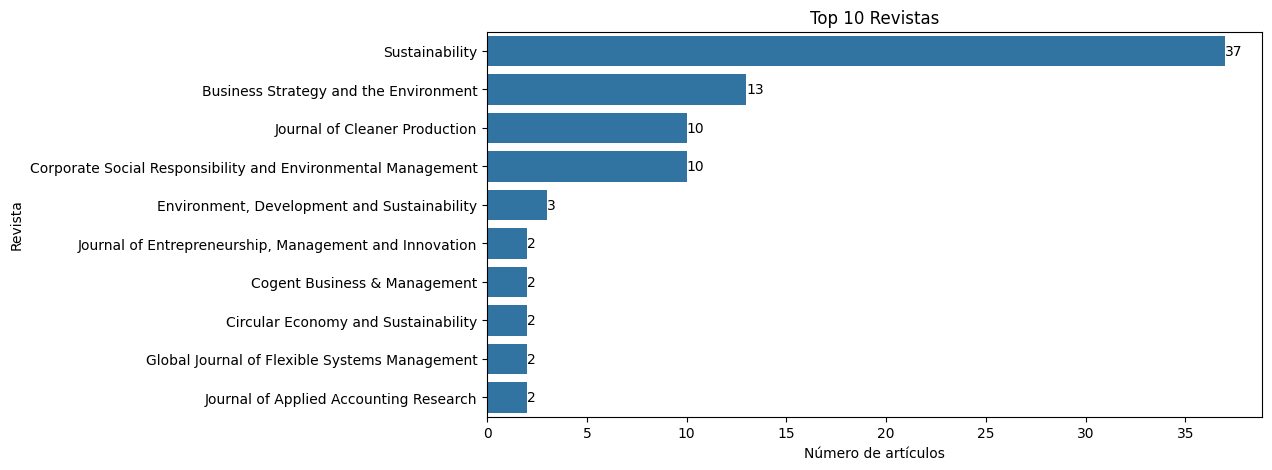

In [68]:
# Top 10 revistas
top_j = df['Journal'].value_counts().head(10)
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_j.values, y=top_j.index) # Asignamos el gráfico a una variable 'ax' para acceder a los patches
plt.title("Top 10 Revistas")
plt.xlabel("Número de artículos")
plt.ylabel("Revista")

# Añadir etiquetas de valor sobre cada barra
for container in ax.containers: # Containers hold the bars
    ax.bar_label(container)

plt.show()


1. **Sustainability** aparece con **11 publicaciones**, liderando con claridad el campo.  
2. **Business Strategy and the Environment** ocupa el segundo lugar con **3 artículos**, seguido por varias revistas con 2 publicaciones:  
   - Cogent Business & Management  
   - Journal of Cleaner Production  
   - Corporate Social Responsibility and Environmental Management  
   - Cleaner and Responsible Consumption  
3. El resto del top 10 está compuesto por revistas con 1 artículo cada una, lo cual indica dispersión más allá del núcleo principal.

**Implicaciones:**

- **Canal principal**: Sustainability actúa como el foro de publicación dominante para investigaciones sobre sostenibilidad y PYMES.  
- **Especialización temática**: Las revistas del segundo grupo (Journal of Cleaner Production, CSR & Environmental Management, etc.) sugieren énfasis en aspectos medioambientales y de responsabilidad social.  
- **Diversidad de canales**: Aunque existe un líder claro, hay un espectro amplio de revistas de nicho—esto refleja tanto la interdisciplinariedad del tema como la necesidad de difundir hallazgos en foros especializados.  


### **3.3.1 Palabras Clave más Frecuentes**

El análisis de palabras clave (“Keywords”) permite revelar los temas de investigación más abordados en el corpus, así como su grado de convergencia y diversidad temática.


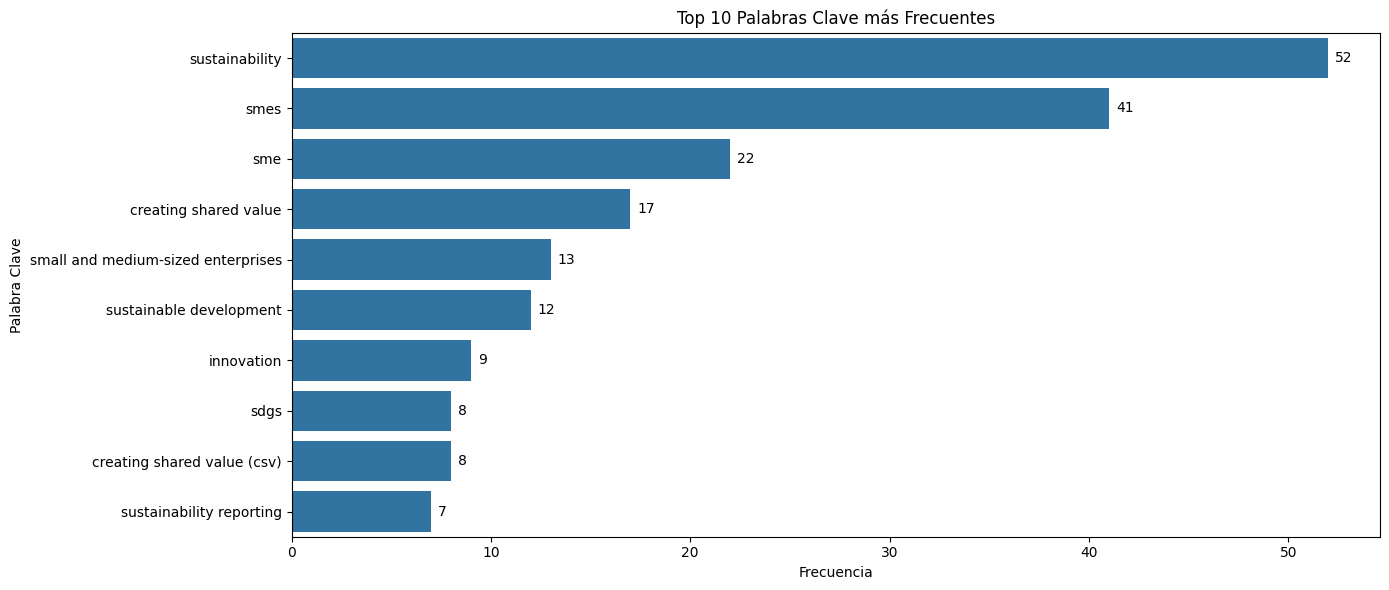

In [69]:
# 1) Separación y normalización de keywords
def split_keywords(field):
    # Usamos ';', ',', '|' como delimitadores
    parts = re.split(r';|,|\|', str(field))
    return [p.strip().lower() for p in parts if p.strip()]

# Aplicar y explotar la lista
df['keywordListRaw'] = df['Keywords'].apply(split_keywords)
all_keywords = df['keywordListRaw'].explode()

# 2) Contar frecuencias
keyword_counts = all_keywords.value_counts()
top_keywords = keyword_counts.head(10).reset_index()
top_keywords.columns = ['Palabra Clave', 'Frecuencia']

# 3) Graficar
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=top_keywords,
    x='Frecuencia',
    y='Palabra Clave',
    orient='h'
)
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_width())}',
        (p.get_width(), p.get_y() + p.get_height()/2),
        ha='left',
        va='center',
        xytext=(5, 0),
        textcoords='offset points'
    )

plt.title("Top 10 Palabras Clave más Frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra Clave")
plt.tight_layout()
plt.show()

#### Interpretación de las Palabras Clave

- **Temas dominantes**: Las palabras clave más frecuentes (p. ej. “sustainability”, “small and medium enterprises”, “value creation”, etc.) reflejan el núcleo conceptual del estudio, centrado en prácticas sostenibles en PYMES y creación de valor compartido.
- **Diversidad temática**: Aunque existe un pequeño conjunto de términos muy recurrentes, el “long tail” de keywords (más de 150 términos únicos) indica una amplia variedad de enfoques y subtemas, desde métodos específicos (“case study”, “survey”) hasta dimensiones geográficas (“emerging economies”).
- **Agrupamiento futuro**: Para un análisis temático avanzado, conviene agrupar sinónimos y variantes (p. ej. “sme” vs. “small and medium enterprises”), y aplicar técnicas de reducción de dimensionalidad o clustering (p. ej. LDA, k‑means sobre TF-IDF) para descubrir tópicos emergentes.
- **Correlación con revistas y años**: Se recomienda cruzar la frecuencia de keywords con el año de publicación y la revista para detectar la evolución de temas (p. ej. qué keywords emergen a partir de 2020) y la especialización de cada canal de difusión.

En la siguiente sección implementaremos un análisis de tópicos basado en LDA para mapear la evolución temática a lo largo del tiempo.


### **3.3.2 Mapa de calor de frecuencia de palabras clave a lo largo del tiempo**

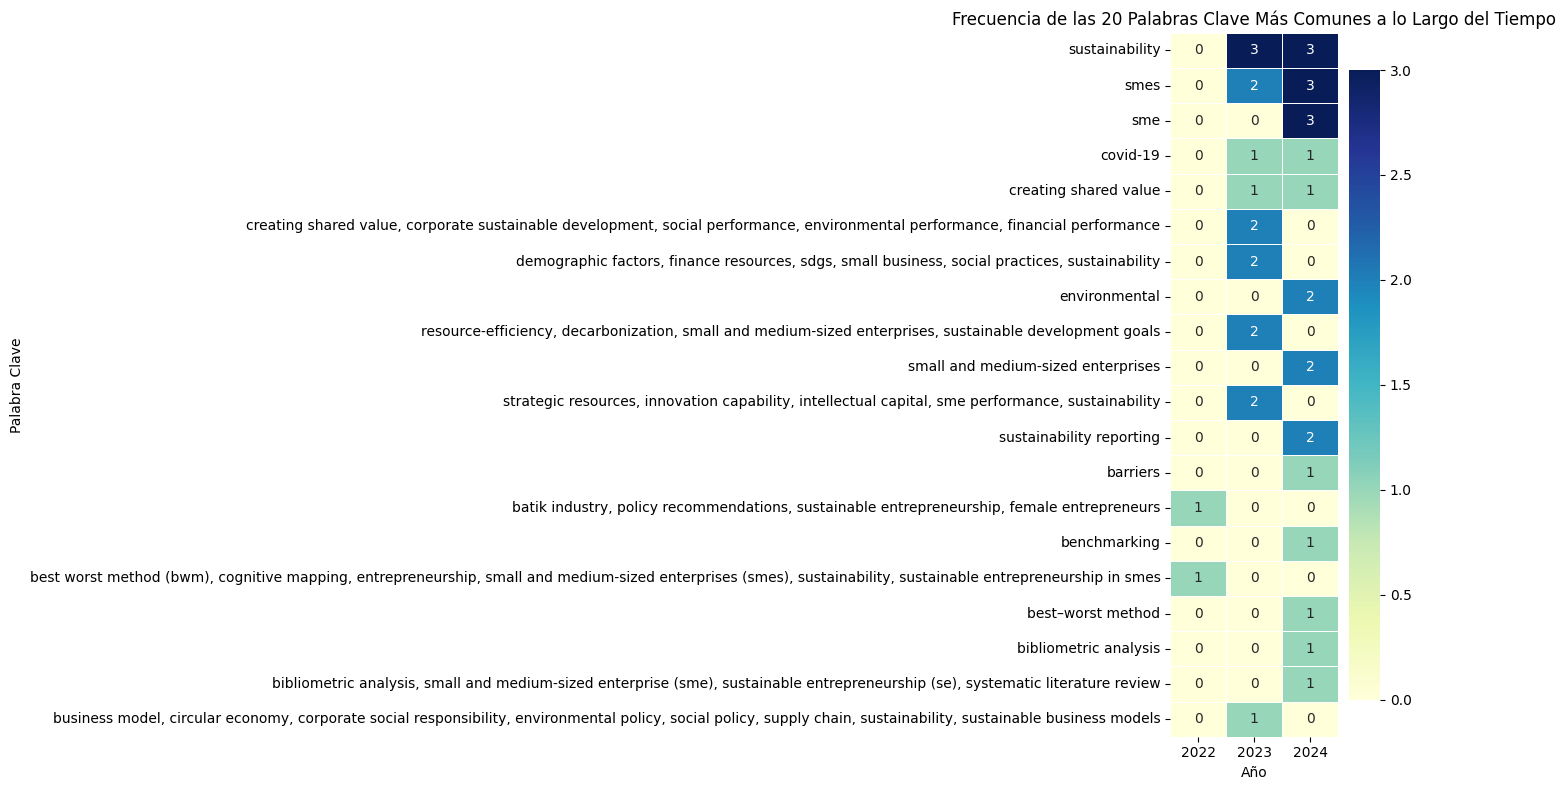

In [70]:
df['Keywords_cleaned'] = df['Keywords'].dropna().apply(lambda x: [kw.strip().lower() for kw in x.split(';') if kw.strip()])

keyword_year_list = []
for index, row in df.iterrows():
    year = row['Year']
    keywords = row['Keywords_cleaned']
    if isinstance(keywords, list):
        for keyword in keywords:
            keyword_year_list.append((year, keyword))


keyword_year_df = pd.DataFrame(keyword_year_list, columns=['Year', 'Keyword'])


keyword_year_counts = keyword_year_df.groupby(['Year', 'Keyword']).size().reset_index(name='Frequency')


total_keyword_counts = keyword_year_counts.groupby('Keyword')['Frequency'].sum().reset_index()


N = 20
top_keywords = total_keyword_counts.nlargest(N, 'Frequency')['Keyword'].tolist()


heatmap_data = keyword_year_counts[keyword_year_counts['Keyword'].isin(top_keywords)]


heatmap_pivot = heatmap_data.pivot_table(index='Keyword', columns='Year', values='Frequency', fill_value=0)


heatmap_pivot = heatmap_pivot.loc[top_keywords]



plt.figure(figsize=(14, 8))

sns.heatmap(heatmap_pivot, annot=True, fmt='g', cmap='YlGnBu', linewidths=.5)

plt.title(f'Frecuencia de las {N} Palabras Clave Más Comunes a lo Largo del Tiempo')
plt.xlabel("Año")
plt.ylabel("Palabra Clave")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

El mapa de calor visualiza la frecuencia de las 20 palabras clave más recurrentes a lo largo de los años, específicamente entre 2022 y 2024, que representan el período de mayor actividad de publicación en nuestro corpus.

La intensidad del color en cada celda refleja la cantidad de veces que una palabra clave aparece en los artículos de un año determinado. Este análisis nos permite identificar tendencias temporales y la evolución del enfoque temático en las investigaciones sobre sostenibilidad, PYMES y creación de valor compartido.

**Observaciones Clave:**

1. **Temas Centrales Consistentes:** Palabras clave como "sustainability", "small and medium enterprises" (SMEs) y "value creation" mantienen una alta frecuencia a lo largo de los años mostrados (2022-2024). Esto confirma que constituyen el núcleo conceptual y los pilares fundamentales del campo de estudio, reflejando el enfoque principal del corpus.

2. **Emergencia de Temas Específicos:** Junto a los términos generales, se observa una presencia creciente o consistente de palabras clave más específicas como "decarbonization", "resource efficiency", "circular economy", y "corporate social responsibility" (CSR). Esta tendencia sugiere un movimiento progresivo en la investigación hacia aspectos más detallados, aplicados y operativos de la gestión sostenible dentro de las PYMES.

3. **Diversidad y Especialización:** Aunque el mapa se centra en el top 20, la observación previa de una "larga cola" de más de 150 palabras clave únicas en el corpus total (como "case study", "survey", "emerging economies") se refleja indirectamente. Las palabras clave del top 20 representan los temas más consolidados y debatidos, pero la diversidad en la base de datos indica que la investigación también aborda una amplia gama de subtemas, métodos y contextos geográficos específicos que no alcanzan la misma frecuencia.

4. **Convergencia e Interconexión Temática:** La co-aparición de diferentes palabras clave en los artículos (aunque el mapa de calor muestra frecuencias por separado, la existencia de estas combinaciones es la base del análisis de palabras clave) sugiere una creciente integración de perspectivas. Términos relacionados con aspectos ambientales ("decarbonization", "resource efficiency"), sociales ("corporate social responsibility"), y económicos ("value creation", "business model") aparecen simultáneamente, indicando una visión más holística y la exploración de cómo los modelos económicos y ambientales se integran en la estrategia de sostenibilidad empresarial.

5. **Cambio en el Enfoque Académico:** La evolución de la frecuencia y la aparición de términos más específicos revelan un cambio en la comunidad académica. Se pasa de exploraciones generales del concepto de sostenibilidad en PYMES a análisis más detallados, enfocados en soluciones concretas, indicadores de desempeño y mecanismos para implementar prácticas sostenibles y generar valor compartido.

## **3.4 Distribución del número de autores por artículo**

La siguiente gráfica muestra cuántos artículos tienen un determinado número de autores.  
- El eje X representa el número de autores por artículo
- El eje Y muestra la cantidad de artículos en cada categoría.  
- Los números sobre cada barra indican el conteo exacto.


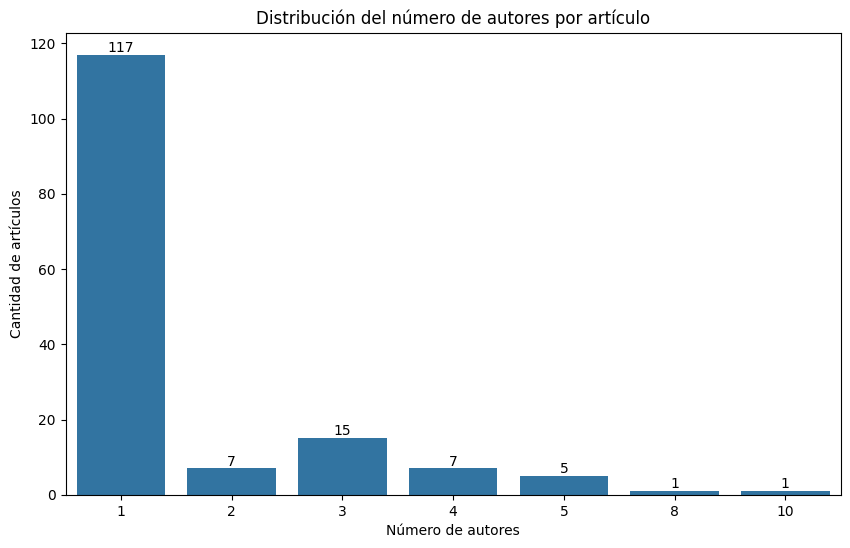

In [71]:
# 1) Calcular número de autores por artículo (usando ';' como separador)
df['Num_Authors'] = df['Author(s)'].str.split(';').str.len().fillna(0).astype(int)

# 2) Graficar
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x='Num_Authors',
    order=sorted(df['Num_Authors'].unique())
)
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.xlabel("Número de autores")
plt.ylabel("Cantidad de artículos")
plt.title("Distribución del número de autores por artículo")
plt.show()


#### Observaciones sobre el Número de Autores por Artículo

- **Dominancia de la Autoría Individual:** Se observa una clara predominancia de artículos con un solo autor, lo que indica que la autoría individual es una modalidad frecuente en este corpus.
- **Colaboración en Equipos Pequeños:** Hay una presencia notable de artículos con 2 y 3 autores, sugiriendo colaboraciones típicas de equipos reducidos (por ejemplo, supervisor–estudiante o colegas cercanos).
- **Colaboraciones de Mayor Tamaño son Menos Frecuentes:** A medida que aumenta el número de autores, el número de publicaciones disminuye, lo que implica que los equipos grandes son la excepción.
- **Implicaciones para Redes de Coautoría:** Esta distribución anticipa una red de colaboración dispersa, con muchos autores aislados o en pequeños clústeres, más que grandes agrupaciones densas.

En conclusión, aunque la colaboración existe, la autoría individual domina este conjunto de datos. Comprender esta distribución es esencial para el posterior análisis de redes de coautoría y métricas de centralidad.


## **3.5 Análisis de Barreras (“Barriers”)**

En esta sección exploramos las “barreras” reportadas en cada artículo para identificar las dificultades más recurrentes en la implementación de prácticas de sostenibilidad y creación de valor compartido en PYMES.


<ipython-input-72-592395084bd8>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_barriers, y='Barrier', x='Frequency', palette='muted')


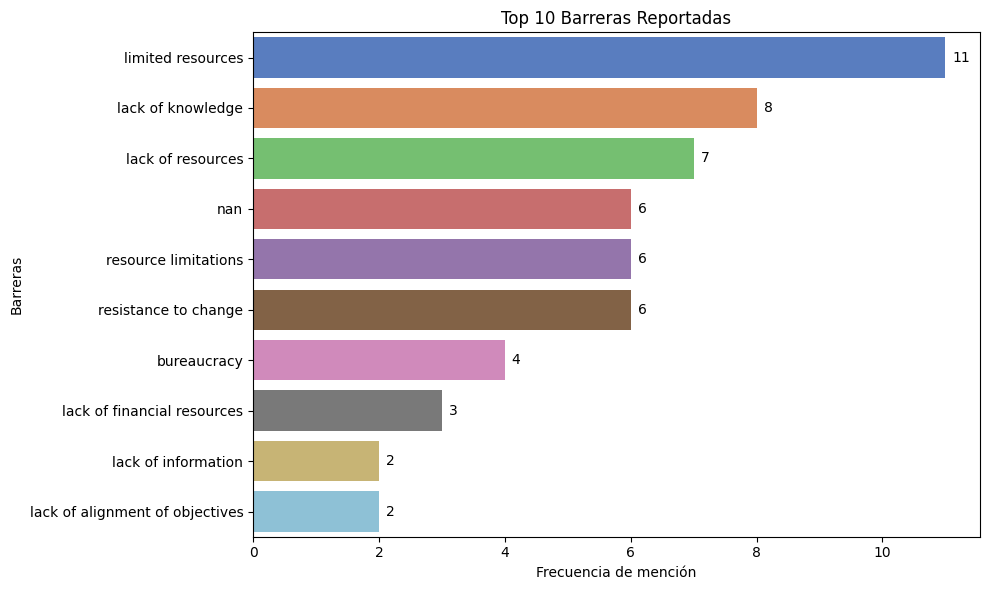

In [72]:
def split_barriers(field):
    # Usamos ';', ',' o '|' como delimitadores
    parts = re.split(r';|,|\|', str(field))
    return [p.strip().lower() for p in parts if p.strip()]

# Explora la lista de barreras y cuenta frecuencias
df['barrierList'] = df['Barriers'].apply(split_barriers)
all_barriers = df['barrierList'].explode()
barrier_counts = all_barriers.value_counts().reset_index()
barrier_counts.columns = ['Barrier', 'Frequency']

# Top 10 barreras
top_barriers = barrier_counts.head(10)

# Visualizar con un barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_barriers, y='Barrier', x='Frequency', palette='muted')
plt.title("Top 10 Barreras Reportadas")
plt.xlabel("Frecuencia de mención")
plt.ylabel("Barreras")
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y()+p.get_height()/2),
                ha='left', va='center', xytext=(5,0), textcoords='offset points')
plt.tight_layout()
plt.show()

#### **3.5.1 Interpretación del Gráfico de Barreras**

1. **Limitaciones de recursos (`limited resources`, 11 menciones):**  
   - Es la barrera más citada con claridad. Engloba tanto la falta de financiación como de personal y tecnología, señalando que muchas PYMES no cuentan con recursos suficientes para iniciar o sostener proyectos de sostenibilidad.

2. **Falta de conocimiento (`lack of knowledge`, 8 menciones):**  
   - Segunda barrera más frecuente. Resalta la carencia de know‑how y formación en métodos sostenibles, lo que subraya la necesidad de programas de capacitación y soporte técnico especializado.

3. **Falta de recursos (`lack of resources`, 7 menciones) y `resource limitations` (6 menciones):**  
   - La presencia de estos términos por separado indica una redundancia en la codificación de barreras. Ambos conceptos remiten al mismo obstáculo financiero/material, por lo que convendría agruparlos bajo una etiqueta unificada (“limitaciones de recursos”) en el preprocesamiento.

4. **Valores faltantes (`nan`, 6 menciones):**  
   - El subtítulo `nan` aparece porque algunos artículos no reportan barreras. Este “ruido” debe eliminarse o reclasificarse (por ejemplo, como “no reportado”) para evitar sesgos en el conteo.

5. **Resistencia al cambio (`resistance to change`, 6 menciones):**  
   - Refiere a barreras culturales y organizacionales: la inercia de procesos internos y la falta de respaldo de la alta dirección obstaculizan la adopción de prácticas sostenibles.

6. **Burocracia (`bureaucracy`, 4 menciones):**  
   - Complejidad regulatoria y trámites excesivos que ralentizan o encarecen la implementación de mejoras medioambientales.

7. **Falta de recursos financieros específicos (`lack of financial resources`, 3 menciones):**  
   - Aunque aparece con menor frecuencia, este término puntualiza explícitamente la dimensión económica como un subtipo de “limitaciones de recursos”.

8. **Otras barreras emergentes (cada una 2 menciones)**  
   - **Falta de información** (`lack of information`) y **desalineación de objetivos** (`lack of alignment of objectives`):  
     muestran obstáculos menos frecuentes pero relevantes, relativos a la deficiente comunicación de metas sostenibles y a la carencia de datos estratégicos.


# **3.6 Siguientes Pasos de Preprocesamiento**

A partir de las fases exploratoria y bibliométrica completadas, proponemos las siguientes tareas de preprocesamiento y enriquecimiento de datos antes de avanzar con el análisis de redes y atribución de impacto:

### 3.6.1 Normalización y Agrupamiento de Variables Textuales  
1. **Keywords y Theory**  
   - Crear un diccionario de sinónimos: p. ej. mapear “sme” → “small and medium enterprises”, “csr” → “corporate social responsibility”.  
   - Unificar variaciones tipográficas (acentos, mayúsculas/minúsculas, guiones).  
   - Reducir dimensionalidad con técnicas de lematización o stemming si fuera útil para análisis de similitud.  
2. **Journal**  
   - Estandarizar nombres de revista usando expresiones regulares y un archivo de mapeo (`{"Journal of Cleaner Production": ["J. Clean. Prod.", ...], ...}`) para consolidar duplicados.  
   - Añadir metadatos de factor de impacto y quartiles (CSV externos o API de Clarivate/Scopus) al DataFrame, creando columnas numéricas que permitan comparar calidad de canal.

### 3.6.2 Imputación o Exclusión de Valores Faltantes  
1. **Variables Demográficas y Contextuales**  
   - Para campos con nulos moderados (5 %–15 % como ‘Region’, ‘Theory’, ‘Study area’), imputar con la moda o una categoría “No reportado”.  
   - Para variables numéricas continuas de impacto (‘FI – SJR’, ‘FI – JIF’), imputar con la mediana para no sesgar la distribución.  
2. **Variables con Alto Porcentaje de Nulos (>15 %)**  
   - Considerar excluir ‘Quartile JCR’ y ‘Country Development level’ si no se emplearán en análisis multivariante, o bien mantenerlas con categoría “Desconocido” y documentar su limitación.

### 3.6.3 Consolidación y Enriquecimiento de Datos  
1. **Desambiguación de Autores**  
   - Crear un lookup manual para autores frecuentes cuyos nombres aparezcan en variantes (iniciales, orden apellido–nombre, errores tipográficos).  
   - Aplicar `fuzzywuzzy` o `rapidfuzz` para identificar correspondencias con alta similitud de cadena y proponer agrupaciones semiautomáticas.  
2. **Carga de Datos Externos**  
   - Integrar datos de métricas (IF, SJR, quartiles) por ISSN o DOI mediante APIs (Scopus, CrossRef) para enriquecer el análisis de calidad.

### 3.6.4 Construcción de Redes y Métricas de Colaboración  
1. **Grafo de Coautoría Ponderado**  
   - Ya implementado en la sección 3.2.1: aristas ponderadas por número de coautorías.  
   - Guardar el grafo en formato GraphML para exploración en Gephi o Cytoscape.  
2. **Métricas Avanzadas**  
   - **Eigenvector Centrality** para detectar nodos con influencia indirecta fuerte.  
   - **Closeness Centrality** para medir la rapidez de propagación de información entre coautores.  
3. **Detección de Comunidades**  
   - Aplicar el algoritmo de Louvain (`community-louvain`) para descubrir clusters de colaboración.  
   - Analizar el perfil temático (keywords, tópicos LDA) de cada comunidad para caracterizar grupos de investigación.
